# CVRP - Part 2

## Heuristic - Sweep algorithm with 2-opt

Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

Choose and import the dataset

In [3]:
filename = "benchmarks.xlsx"
sheet_name = "54_nodes"        # Choose "53_nodes" or "101_nodes"
capacity = 100                 # 100 for "53_nodes", 112 for "101_nodes" 

df = pd.read_excel(filename, sheet_name=sheet_name)
df.head()

,Location,X,Y,Demand
0,1,61,5,0
1,2,85,53,24
2,3,17,57,9
3,4,49,93,15
4,5,69,11,17


### Sweep Algorithm

In [4]:
def choose_file():
    """
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """    #choose between df51 and df101
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands


def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def calculate_distance_matrix(coordinates):
    """
    Calculate the distance matrix between coordinates.
    """
    num_points = len(coordinates)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = calculate_distance(coordinates, i, j)

    return dist_matrix

def calculate_total_distance(route, dist_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_distance = 0
    num_points = len(route)

    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_distance += dist_matrix[current_node, next_node]

    return total_distance

def calculate_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

def calculate_distance_matrix(coordinates):
    num_points = len(coordinates)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = calculate_distance(coordinates[i], coordinates[j])

    return dist_matrix

def sort_customers_by_distance(coordinates, depot_index):
    depot_coord = coordinates[depot_index]
    distances = [calculate_distance(depot_coord, coord) for coord in coordinates]
    sorted_customers = sorted(range(len(coordinates)), key=lambda x: distances[x])
    return sorted_customers

def sort_customers_by_demand(demands):
    sorted_customers = sorted(range(len(demands)), key=lambda x: demands[x], reverse=True)
    return sorted_customers

def sweep_algorithm(coordinates, demands, capacity, depot_index=0):
    num_points = len(coordinates)
    angles = np.arctan2(coordinates[:, 1], coordinates[:, 0])
    sorted_customers = sorted(range(1, num_points), key=lambda x: angles[x])

    routes = []
    current_route = [depot_index]
    remaining_capacity = capacity

    for customer in sorted_customers:
        demand = demands[customer]

        if demand <= remaining_capacity:
            current_route.append(customer)
            remaining_capacity -= demand
        else:
            current_route.append(depot_index)  # Return to depot
            routes.append((current_route, capacity - remaining_capacity))  # Save route and used capacity
            current_route = [depot_index, customer]
            remaining_capacity = capacity - demand

    current_route.append(depot_index)  # Return to depot
    routes.append((current_route, capacity - remaining_capacity))  # Save route and used capacity

    return routes




Visualization of the cost matrix

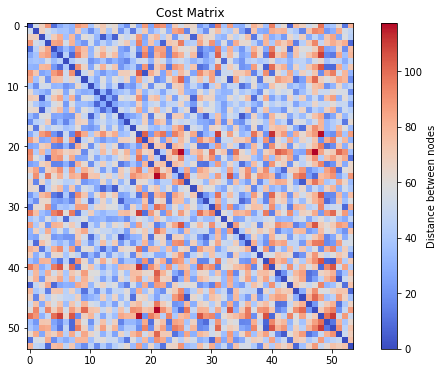

In [5]:
# Cost matrix
coordinates, demands = choose_file()
distance_matrix = calculate_distance_matrix(coordinates)

# Plot cost matrix as a heatmap
plt.figure(figsize=(10,6))
plt.imshow(distance_matrix, cmap= 'coolwarm')
plt.colorbar(label='Distance between nodes')
plt.title('Cost Matrix')
plt.show()

Find the solution using the defined algorithm

In [6]:
coordinates, demands = choose_file()
dist_matrix = calculate_distance_matrix(coordinates)

start_time = time.time()

# Apply the Sweep Algorithm 
routes = sweep_algorithm(coordinates, demands, capacity)

end_time = time.time() 
total_distance = 0

# Calculate total distance
for route, _ in routes:
    route_distance = calculate_total_distance(route, dist_matrix)
    total_distance += route_distance

execution_time = end_time - start_time

# Print routes and capacity used in each route
for idx, (route, capacity_used) in enumerate(routes):
    print(f"Route {idx + 1}: {route}, Capacity Used: {capacity_used}")
    
    
print("")
print(f"Total cost: {total_distance}")
print("Sweep algorithm execution time:", execution_time, "seconds")

Route 1: [0, 30, 18, 4, 5, 43, 28, 52, 50, 0], Capacity Used: 92
Route 2: [0, 7, 39, 20, 23, 49, 34, 16, 29, 35, 36, 15, 0], Capacity Used: 87
Route 3: [0, 10, 1, 6, 45, 17, 26, 32, 0], Capacity Used: 94
Route 4: [0, 25, 21, 38, 9, 41, 33, 13, 11, 0], Capacity Used: 98
Route 5: [0, 44, 53, 3, 46, 0], Capacity Used: 78
Route 6: [0, 22, 27, 14, 2, 12, 19, 0], Capacity Used: 99
Route 7: [0, 8, 31, 42, 37, 51, 40, 47, 0], Capacity Used: 96
Route 8: [0, 24, 48, 0], Capacity Used: 25

Total cost: 2361.56067496668
Sweep algorithm execution time: 0.0003287792205810547 seconds


Visualization of the results

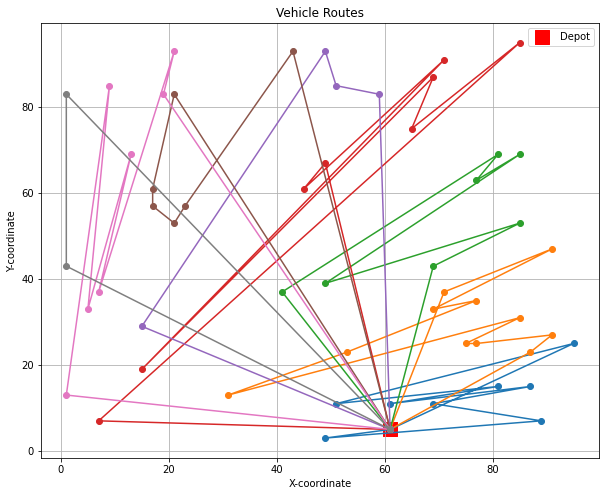

In [7]:
def plot_routes(routes, coordinates):
    plt.figure(figsize=(10, 8))
    for route, capacity_used in routes:
        route_coords = coordinates[route]
        plt.plot(route_coords[:, 0], route_coords[:, 1], marker='o')

    # Plot depot
    plt.scatter(coordinates[0][0], coordinates[0][1], marker='s', color='red', s=200, label='Depot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_routes(routes, coordinates)

### Using 2-opt to improve the Sweep algrotihm results

In [8]:
def calculate_route_distance(route, dist_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_improved_distance = 0
    num_points = len(route)

    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_improved_distance += dist_matrix[current_node, next_node]

    return total_improved_distance

def two_opt(route, dist_matrix):
    """
    Apply the 2-opt heuristic to improve the given route.
    """
    improved = True
    best_distance = calculate_route_distance(route, dist_matrix)

    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue  # No need to consider adjacent edges

                new_route = route[:i] + route[i:j][::-1] + route[j:]

                new_distance = calculate_route_distance(new_route, dist_matrix)
                if new_distance < best_distance:
                    route = new_route
                    best_distance = new_distance
                    improved = True
                    break
            if improved:
                break

    return route, best_distance

start_time = time.time()

improved_routes = []
total_improved_distance = 0  # Initialize total distance

for route, _ in routes:
    improved_route, route_distance = two_opt(route, dist_matrix)
    improved_routes.append(improved_route)
    total_improved_distance += route_distance

    
end_time = time.time()    


# Print improved routes
for idx, route in enumerate(improved_routes):
    print(f"Improved Route {idx + 1}: {route}")


execution_time = end_time - start_time
print("Improved Sweep algorithm execution time:", execution_time, "seconds")    
    
print("")
print(f"Total cost: {total_improved_distance}")

Improved Route 1: [0, 18, 50, 5, 28, 4, 43, 52, 30, 0]
Improved Route 2: [0, 34, 16, 35, 15, 29, 36, 49, 39, 7, 20, 23, 0]
Improved Route 3: [0, 1, 45, 26, 17, 10, 6, 32, 0]
Improved Route 4: [0, 21, 33, 9, 38, 11, 13, 41, 25, 0]
Improved Route 5: [0, 44, 3, 53, 46, 0]
Improved Route 6: [0, 14, 27, 2, 12, 19, 22, 0]
Improved Route 7: [0, 8, 31, 40, 37, 42, 51, 47, 0]
Improved Route 8: [0, 24, 48, 0]
Improved Sweep algorithm execution time: 0.00941920280456543 seconds

Total cost: 1614.8539209433275


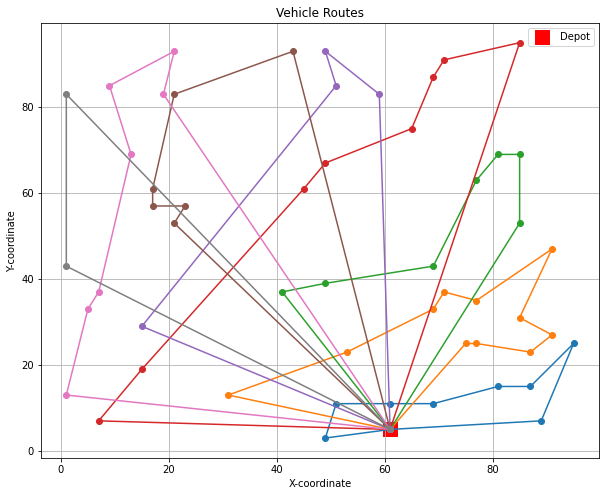

In [9]:
def plot_routes(routes, coordinates):
    plt.figure(figsize=(10, 8))
    for route in routes:
        route_coords = coordinates[route]
        plt.plot(route_coords[:, 0], route_coords[:, 1], marker='o')

    # Plot depot
    plt.scatter(coordinates[0][0], coordinates[0][1], marker='s', color='red', s=200, label='Depot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot the improved routes
plot_routes(improved_routes, coordinates)